# Data visualisation with python

Let's import the libraries and datasets we need:

In [13]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# do not display the number with scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [14]:
path = 'data/eniac/'

import os
path, dirs, files = next(os.walk(path))
        
print(files)

# create empty list 
df_list = []

# append datasets to the list
for file in files: 
    temp_df = pd.read_csv(path + file, sep=',')
    df_list.append(temp_df)

# show results
orders, orderlines, products, brands = df_list[0], df_list[1], df_list[2], df_list[3]

['brands.csv', 'orderlines.csv', 'orders.csv', 'products.csv']


Transform to date format the columns from orders and orderlines:

In [15]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


In [16]:
orders['created_date'] = pd.to_datetime(orders['created_date'])
orderlines['date'] = pd.to_datetime(orderlines['date'])

KeyError: 'created_date'

In [ ]:
products['price'].mean()

## Company revenue

First I will need to filter only the orders that have a completed state: 

In [ ]:
orders_compl = orders.query('state == "Completed"')

Before we create a visualisation, we always need to prepare our dataframe: 

In [ ]:
p_df = (
orders_compl
    # create two new columns in our dataframe; year and month
    .assign(year = orders['created_date'].dt.strftime('%Y'), 
           month = orders['created_date'].dt.strftime('%b'))
    # get the total paid by each year and month
    .groupby(['year','month'])
    .agg({'total_paid':'sum'})
    # reset the index to user the column vector in our plot
    .reset_index()
)
p_df

In [ ]:
# Create a list with the months sorted from January to December
# It is going to help us sort our columns appropriately
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# define de size of the plot: 12 with be the width, and 8 the height
plt.subplots(figsize=(12, 8))


p = sns.barplot(
    data=p_df, # dataframe we will use to look for the columns information
    x='month', # x values on our chart
    y='total_paid', # y values on our chart
    hue='year', # group color in our chart
    order=months # order x columns
)
# add a horizontal reference line into the chart to know where the mean value will be
p.axhline(
    p_df['total_paid'].mean(), # value where you want to add your reference line
    linestyle='--', # type of line you would like to see on the plot. You can find more informaiton on its documentation
    color='gray'
)

plt.xlabel('Month') # x label name
plt.ylabel('Total paid') # y label name
plt.title('Total paid evolution through 2017 and 2018') # title
plt.ticklabel_format(style='plain', axis='y') # remove scientific notation for the y axis
plt.show() # show the plot

### Revenue distribution by order id

I would like to know more about the different values of `total_paid` for each order by month.

Let's talk more about this concept: 

In [ ]:
p_df = (
orders_compl
    # create year and month
    .assign(year = orders['created_date'].dt.strftime('%Y'), 
           month = orders['created_date'].dt.strftime('%b'))
)
p_df

If we create a barplot directly: 

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.subplots(figsize=(12, 8))

sns.barplot(data=p_df, x='month', y='total_paid', hue='year', order=months)

plt.xlabel('Month')
plt.ylabel('Total paid')
plt.title('Total paid evolution through 2017 and 2018')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Look at the description of `?sns.barplot` to undersand more about the chart. What's the meaning of the dark lines on top of each bar?

A better way to see the distribution by month would be to use another type of chart; the boxplot. 

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.subplots(figsize=(12, 8))

sns.boxplot(data=p_df, x='month', y='total_paid', hue='year', order=months)

plt.ylim(0, 800) # define a limit to put focus on your chart
plt.xlabel('Month')
plt.ylabel('Total paid')
plt.title('Total paid evolution through 2017 and 2018')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

What I am seeing on this chart? Well, the [boxplot](https://en.wikipedia.org/wiki/Box_plot) is a representaition of the pandas function `.describe()`. It shows the main descriptive statistics of a distribution. 

In [ ]:
(
p_df
    # select this 3 columns
    .filter(['year','month','total_paid'])
    # apply the describe function to this two groups
    .groupby(['year','month'])
    .describe()
)

As you can see, most of our transactions have monthly median values around 100, but maximum values go up to 10,000 and the standard deviation is huge. So we have very different types of customers. 

A possible hypothesis is that we have a large group of low-paying customers who are end-users and a small group of 'whale' customers who are companies. What's your hypothesis?

### Revenue: zoom in January

We can zoom into the distribution of one month by filtering one month in our dataset:

In [ ]:
p_df_jan = p_df.query('month == "Jan"')

In [ ]:
plt.subplots(figsize=(12, 8))

sns.histplot(data=p_df_jan, x='total_paid', hue='year', 
             alpha=.3, # add transparency to you chart
             kde=True, # add a density line in the histogram
             bins=1000 # define the number of bins the variable total paid will be grouped
            )

plt.xlim(0, 2000)
plt.title('Comparing the distributions of total paid between Jan 2017/18')
plt.xlabel('Total paid')
sns.despine() # remove the top and right margin, to make your plot prettier 
plt.show()

Looking at this distributions, we can see that in 2017 there have been more orders with a `total_paid` smaller than in 2018. While in 2018 we have several spikes between 1000 and 1500, which indicates that there are more orders with a higer price in average. 

Let's check this hypothesis: 

In [ ]:
p_df_jan.groupby('year').agg({'total_paid':['mean','median','std']})

My theory is confirmed when we aggregate the data. The standard deviation for 2018 also shows us that there is a higher dispersion compared to 2017, caused mainly but these orders around 1250 euros.

Let's see if we can zoom in into the products information for january. 

In [12]:
# we already have the completed orders for January of both year in our p_df_jan, let's it to locate them on the orderlines file
p_sku_jan = (
orderlines
    # filter all the orders id in orderlines for month of january (2017 and 2018)
    .loc[orderlines['id_order'].isin(p_df_jan['order_id'])]
    .assign(year = orderlines['date'].dt.strftime('%Y'))
    .groupby(['year','sku'])
    .agg({'unit_price':'sum'})
    .reset_index()
    .sort_values('unit_price', ascending=False)
    .groupby('year')
    .head(10)
)
p_sku_jan

NameError: name 'p_df_jan' is not defined

In [17]:
p_sku_jan = p_sku_jan.merge(products, how='left')
p_sku_jan

,year,sku,unit_price,name,desc,price
0,2017,PAC1240,21966.00,"Apple MacBook Pro 133 ""i5 25GHz | RAM 16GB | 5...",Apple MacBook Pro 133 inches (MD101Y / A) with...,1899.00
1,2017,LGE0044,20341.65,"LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 USB-C",99% Professional Monitor sRGB color calibrator...,599.00
2,2017,APP1810,17399.89,"Apple MacBook Pro 13 ""Core i5 2GHz | 8GB RAM |...",MacBook Pro 13 inch i5 2GHz with 8GB RAM and 2...,1699.00
3,2017,APP1940,12564.93,"Apple MacBook Pro Retina 13 ""i5 27 Ghz | RAM 1...",MacBook Pro 13-inch Retina display 27 Ghz i5 |...,1924.00
4,2017,PAC1035,12043.96,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 32GB |...",IMac desktop computer 27 inch 5K Retina 4GHz i...,3649.00
5,2017,APP1818,11939.96,"Apple MacBook Pro 15 ""Core i7 Touch Bar 27GHz ...",New MacBook Pro 15-inch Touch Bar to 27GHz Cor...,3199.00
6,2017,APP1876,11644.97,"Apple MacBook Pro 15 ""Core i7 Touch Bar 29GHz ...",New MacBook Pro 15-inch Core i7 Touch Bar 29Gh...,4039.00
7,2017,WAC0090,10183.36,"Wacom Cintiq 13HD Graphic Tablet 13 ""LED",Graphics Tablet 13-inch LED HD display with 20...,899.99
8,2017,LGE0047,8819.93,"LG 38UC99-W Monitor 38 ""UHD 4K USB 3.0 USB-C",Monitor curved 38 inch IPS 4K ultra high defin...,1299.00
9,2017,PAC0963,8366.97,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 32GB |...",IMac desktop computer 27 inch 5K Retina 4GHz i...,3409.00


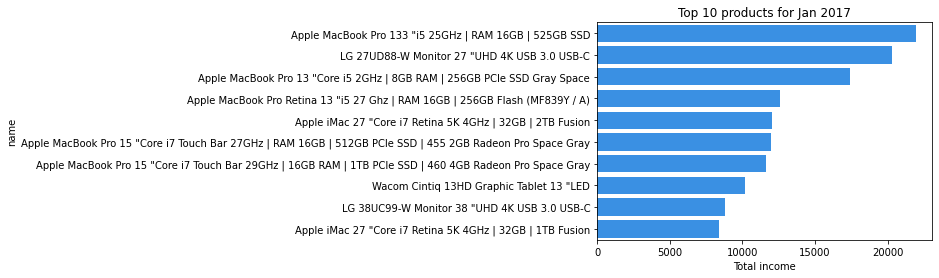

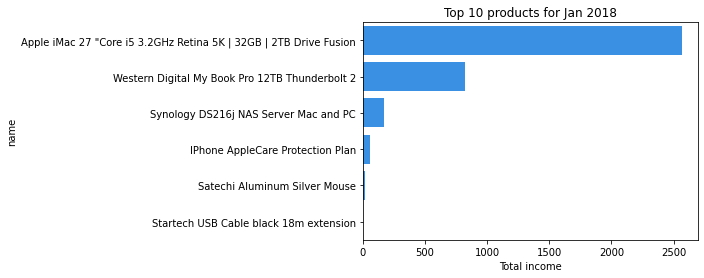

In [18]:
for year in ['2017', '2018']:
    temp = p_sku_jan.loc[p_sku_jan['year'] == year]
    sns.barplot(data=temp, x='unit_price', y='name', color='dodgerblue')
    plt.title('Top 10 products for Jan ' + year)
    plt.xlabel('Total income')
    plt.show()

The [product mix](https://en.wikipedia.org/wiki/Marketing_mix) of the company has changed across the two years. Also the revenue!

Let's do a step back and see if I can find more information about the evolution of mean and median order value across the months:

In [19]:
p_df = (
orders_compl
    .assign(
        # we can create periods of time, in that case year and mont periods. 
        # I recommend you look more in deep and the documentaion of `to_period`
        year_month = orders_compl['created_date'].dt.to_period(freq='M')
    )
    # group by year and month period to find the mean and median value
    .groupby('year_month')
    .agg({'total_paid':['mean','median']})
    .reset_index()
    
)

In [20]:
# rename columns to make it easier to call them on the plot
p_df.columns = ['year_month','mean','median']

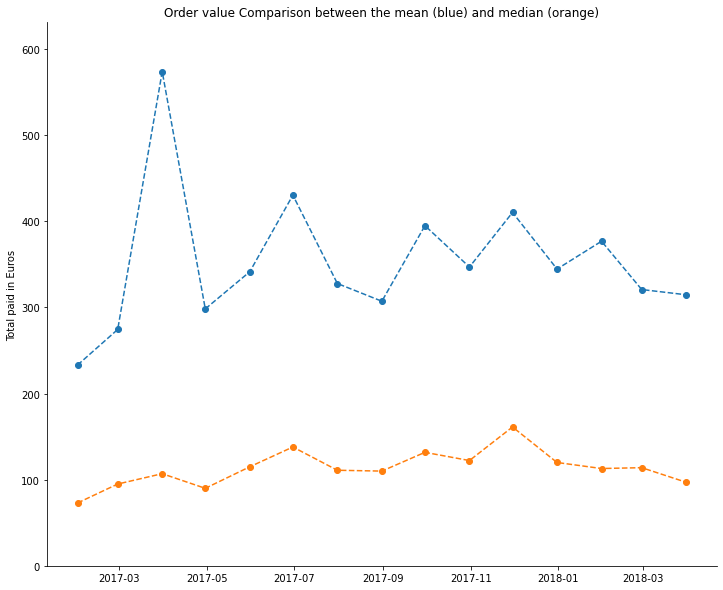

In [21]:
plt.subplots(figsize=(12, 10))

# seaborn and matplotlib works with layers, so you can put one on top of each other.
# using a for look will help us to print as many plots as we want on top of each other
for measure in ['mean','median']: 
    # plot_date help us to plot datetime plots, as it can understand datetime formats like periods
    plt.plot_date(data=p_df, x='year_month', y=measure, linestyle='--')

plt.title('Order value Comparison between the mean (blue) and median (orange)')
plt.xlabel('')
plt.ylabel('Total paid in Euros')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, p_df['mean'].max() * 1.1)
sns.despine()
plt.show()

Which are the main conclusions we can extract from this graph? Which is the difference between using the mean and the median?

## Looking for a correlation between shipping cost, total price and quantity of products by each order 

Is there a correlation between the number of products acquired and the shipping cost? 

In [33]:
p_df = (
orderlines
    .groupby(['id_order'])
    .agg({'total_price':'sum', 
         'product_quantity':'sum'})
    .reset_index()
    .merge(orders, how='left', left_on='id_order', right_on='order_id')
    .query('state == "Completed"')
    # lambda function inside assign help us to call a variable create on the pandas pipeline
    # further explanation below
    .assign(ship_cost = lambda x: x['total_paid'] - x['total_price'])
    # exclude orders with no shippping cost
    .query('ship_cost != 0')
    .groupby('id_order')
    .agg({'ship_cost':'sum',
         'total_price':'sum', 
         'product_quantity':'sum'})
    .sort_values('product_quantity')
)

In [23]:
# Example how to understand a lambda function inside assign

# create a dummy dataframe
temp = pd.DataFrame({
    'x':[1,2,3],
    'y':[2,3,4]
})

# example how it is applied
print('Exemple 1:')
print(
temp
    .assign(x_y = temp['x'] + temp['y'])
    # the only way to call the variable x_y in the same data pipeline is to use 
    # a lambda function, as the variable x_y do not exist on the original dataframe
    .assign(x__x_y = lambda x: x['x'] + x['x_y'])
)

# this process will be exaclty as doing
print('\nExemple 2:')
temp = temp.assign(x_y = temp['x'] + temp['y'])
# in this example I can call the variable as temp['x_y'] as I overwrited the object temp in the line above
print(temp.assign(x__x_y = temp['x'] + temp['x_y']))

Exemple 1:
   x  y  x_y  x__x_y
0  1  2    3       4
1  2  3    5       7
2  3  4    7      10

Exemple 2:
   x  y  x_y  x__x_y
0  1  2    3       4
1  2  3    5       7
2  3  4    7      10


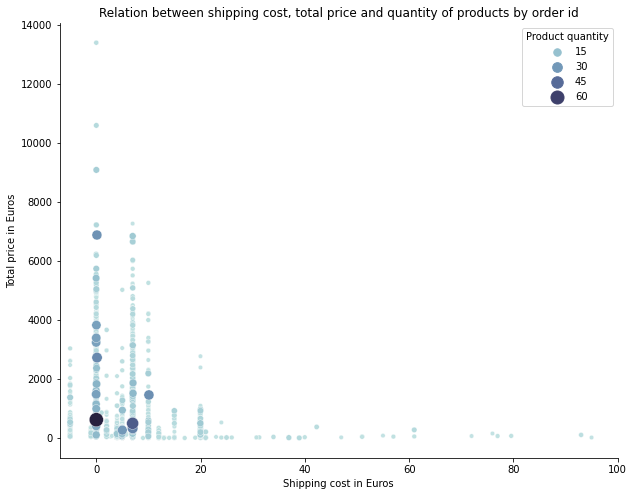

In [24]:
plt.subplots(figsize=(10, 8))

sns.scatterplot(data=p_df, x='ship_cost', y='total_price', 
                hue='product_quantity', 
                size='product_quantity', # define the size of each point based on the variable product quantity
                sizes=(20, 200), # range of size of the size variable
                palette='ch:start=.2,rot=-.3') # define manually the range of colors

plt.xlabel('Shipping cost in Euros')
plt.ylabel('Total price in Euros')
plt.title('Relation between shipping cost, total price and quantity of products by order id')
plt.legend(title = 'Product quantity') # Change the title name of the legend
plt.xlim(-7, 100)
sns.despine()
plt.show()

## CHALLENGE

Answer the following questions with the chart you consider better: 

1. Only a fraction of the total number of orders end up being completed. Let's call this fraction (Completed orders / Total number of orders) 'Orders Conversion Rate'. Can you plot the weekly evolution of the 'Orders Conversion Rate'? Find the best chart to represent it. 

HINT: Trends throughout time are best represented by lines. Search how to do line plots with Seaborn.

If you combine the unit prices from the products dataframe with the unit price in orderlines, you can find if a discount has been applied into a product and how much is the difference. Find out which are the best visualisation to: 

1. Show the evolution of the average discount (in %) by each month

2. Show the top 30 products with the highest discounts in absolute values, on average.  

3. Show the distributions of discounts for each brand. Choose the discount measure you consider better to compare all brands. HINT: you can use the first 3 characters of the sku name to merge it with the brands table.